<a href="https://colab.research.google.com/github/visiont3lab/machine-learning-course/blob/main/classification/ClassNotesClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Scaricare il repositorio da github per avere accesso alle immagini
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

Cloning into 'covid-mask-classifier'...
remote: Enumerating objects: 1088, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1088 (delta 27), reused 15 (delta 3), pack-reused 1013
Receiving objects: 100% (1088/1088), 89.32 MiB | 23.97 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [1]:
import os
import shutil
import cv2
import numpy as np
from PIL import Image

X = []    #0          1    
Y = []  #"mask" , "no-mask"

grayscale = False
size = 128
folder_dataset = "/content/covid-mask-classifier/dataset/"
class_names = ["mask","no-mask"]
for class_name in class_names:
  names = os.listdir(os.path.join(folder_dataset,class_name))
  for name in names:
    filepath = os.path.join(folder_dataset,class_name, name) 
    #print(filepath )

    if grayscale:
      im = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) # BGR
    else:
      im = cv2.imread(filepath, cv2.IMREAD_COLOR) # BGR
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Resize
    im = cv2.resize(im, (size,size))

    X.append( im.reshape(-1) )
    #print(im.shape)

    if class_name == "mask":
      Y.append(0)
    else:
      Y.append(1)
    #display(Image.fromarray(im))

X = np.array(X,dtype=float)
Y = np.array(Y,dtype=float)


0.0


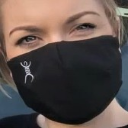

0.0


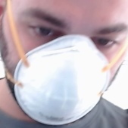

0.0


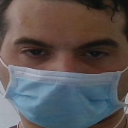

In [2]:
# Check
v = np.random.randint(0,len(Y),3)
for i in v:

  #print(X[i])
  print(Y[i])

  if grayscale:
    display(Image.fromarray(np.uint8(X[i].reshape(size,size))))
  else:
    display(Image.fromarray(np.uint8(X[i].reshape(size,size,3))))

In [3]:
# train test
from sklearn.model_selection import train_test_split
# Train e test data
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.20,shuffle=True, random_state=25)


In [12]:
from sklearn.preprocessing import  MinMaxScaler  
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import precision_score,recall_score, accuracy_score, f1_score
#from sklearn.externals import joblib
from sklearn.decomposition import PCA
import pickle

pipe = Pipeline([
    ("normalize", MinMaxScaler(feature_range=(0,1))), 
    ("pca", PCA(0.999)), 
    ("model", SVC()),
])
pipe.fit(X_train,y_train)

y_train_hat = pipe.predict(X_train)
y_test_hat = pipe.predict(X_test)

# Save 
pickle.dump(pipe, open("model.pkl", 'wb'))

In [13]:
precision = precision_score(y_test,y_test_hat)
recall = recall_score(y_test,y_test_hat)
accuracy = accuracy_score(y_test,y_test_hat)
f1 = f1_score(y_test,y_test_hat,average="weighted")
print("precision:", precision)
print("recall:", recall)
print("accuracy:", accuracy)
print("f1:", f1)


precision: 0.96
recall: 0.9795918367346939
accuracy: 0.97
f1: 0.97000300030003


In [6]:
from sklearn.metrics import confusion_matrix
import pandas as pd
# 0  mask  1 senza
cm_train = confusion_matrix(y_train,y_train_hat)
cm_test = confusion_matrix(y_test,y_test_hat)
df_train = pd.DataFrame(cm_train, columns=["Pred-Mask","Pred-No-Mask"], index=["Real-Mask","Real-No-Mask"])
df_test = pd.DataFrame(cm_test, columns=["Pred-Mask","Pred-No-Mask"], index=["Real-Mask","Real-No-Mask"])
print("TRAIN")
display(df_train)
print("TEST")
display(df_test)

TRAIN


,Pred-Mask,Pred-No-Mask
Real-Mask,393,4
Real-No-Mask,0,402


TEST


,Pred-Mask,Pred-No-Mask
Real-Mask,99,3
Real-No-Mask,2,96


In [11]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.999)
X_pca = pca.fit_transform(X)
print(X.shape)
print(X_pca.shape)

(999, 49152)
(999, 917)


In [14]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


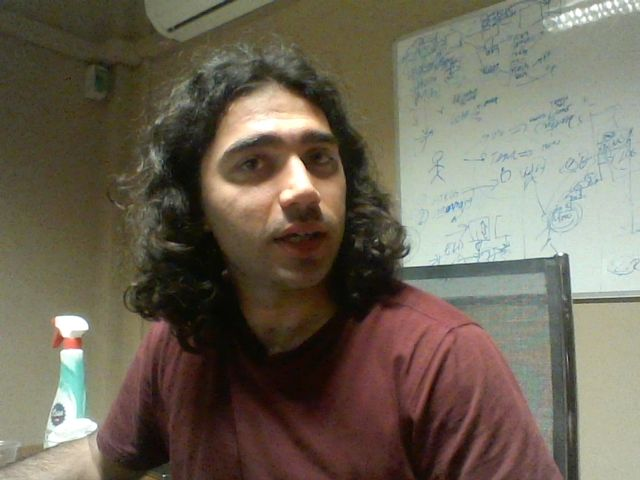

In [15]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

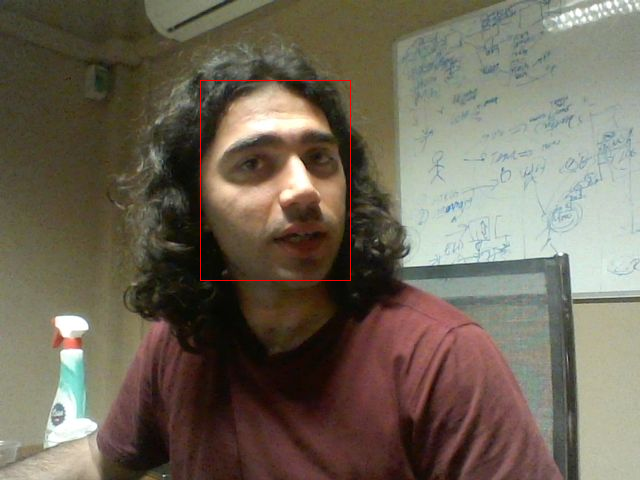

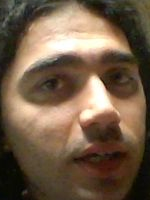

In [27]:
import cv2
from PIL import Image
im = cv2.imread("photo.jpg", cv2.IMREAD_COLOR) # BGR
im = cv2.cvtColor(im,  cv2.COLOR_BGR2RGB)

x = 200
y = 80
w = 150
h = 200
imvis = cv2.rectangle(im.copy(),(x,y),(x+w,y+h), (255,0,0) )

display(Image.fromarray(imvis))

roi = im[y:y+h,x:x+w]

display(Image.fromarray(roi))

In [29]:
# Usare il modello
xx = cv2.resize(roi, (128,128))
xx = xx.reshape(1,-1)
pipe.predict(xx)

array([1.])